![picture](./img/twitter_title.png)

# Project Goal:

#### Create a model that can classify tweet sentiment in order to identify product concerns.

- The goal of this project is to analyze a dataset that contains strings of tweets representing customers' comments on different tech products like Apple Apps, iPad, iPhone, Android...etc. The aim is to create a model that can classify tweet sentiment and identify product concerns. By analyzing the tweets we can gain insights to the customers' opinions of the various products and understand where marketing/product campaigns may want to focus their attention on.

How do we determine sentiment?

1. **Categorize**: Category word frequency Minimize shared words

2. **Understand**: Remove meaningless words

3. **Predict**: Use classification algorithms and hyperameter tuning to create a predictive model that targets Positive, Neutral, and Negative emotion based on each targets most impactful words.

___

# Business Case:

### Social media is a powerful tool for connecting with your customer base.

- Analyzing customer feedback is crucial for companies to stay competitive. Twitter sentiment analysis provides a scalable method to understand customer sentiment. Our client, a tech company that produces mobile devices, wants to analyze a dataset of tweets to identify customer concerns and improve their products. By analyzing the dataset, we will identify common concerns and positive sentiments, allowing the client to develop targeted marketing strategies and improve customer satisfaction.

___

# Exploratory Data Analysis:

### Data Overview:
- [Provided by Flatiron School](https://data.world/crowdflower/brands-and-product-emotions)
- Originally Collected by Appen
- Twitter Brand and Sentiment Data
- Text of ~9100 Tweets
- Human-Analyzed Tweet Sentiments
- Human-Analyzed Brand Targets

The dataset comprises 9092 tweets collected primarily from attendees of the South by Southwest (SXSW) electronics expo. Each tweet in the dataset includes the tweet's text, the brand referenced in the tweet, and the emotions expressed by the tweet's author, as determined by a surveyor. The emotions expressed in the tweets are categorized as Positive, Negative, Neutral/No emotion, or Unclear. This dataset can be used to analyze consumer sentiment towards different brands at the SXSW event and to gain insights into the overall reception of the event.

Upon examining our dataset, we find that 60% of the tweets are neutral, 33% are positive, and only a handful (6.5%) are negative. To get a more balanced view of consumer sentiment, we will need to over-sample the negative tweets. However, we should also bear in mind that this dataset may not be representative of Twitter at large and that these results are specific to the dataset gathered.

## 1. Importing Necessary Packages

In [49]:
import pandas as pd
import numpy as np
import re

from IPython.display import Markdown

from joblib import parallel_backend, dump, load

from nltk.corpus import stopwords, wordnet
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, make_scorer, log_loss, plot_confusion_matrix

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, \
            GridSearchCV

from imblearn.over_sampling import SMOTENC, SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from wordcloud import WordCloud

from code.cleaner import preprocess
from code.viz import word_plot
from code.scoring import custom_scorer

sns.set()

## 2. Examining Our Features & Targets

In [57]:
sentiments = pd.read_csv(
    './data/judge-1377884607_tweet_product_company.csv',
    encoding='ISO-8859-1')
sentiments.tail()

tweet_text  \
9088                      Ipad everywhere. #SXSW {link}   
9089  Wave, buzz... RT @mention We interrupt your re...   
9090  Google's Zeiger, a physician never reported po...   
9091  Some Verizon iPhone customers complained their...   
9092  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...   

     emotion_in_tweet_is_directed_at  \
9088                            iPad   
9089                             NaN   
9090                             NaN   
9091                             NaN   
9092                             NaN   

     is_there_an_emotion_directed_at_a_brand_or_product  
9088                                   Positive emotion  
9089                 No emotion toward brand or product  
9090                 No emotion toward brand or product  
9091                 No emotion toward brand or product  
9092                 No emotion toward brand or product

In [3]:
# sentiments['product'] = sentiments['emotion_in_tweet_is_directed_at']
# sentiments['sentiment'] = sentiments['is_there_an_emotion_directed_at_a_brand_or_product']

sentiments.rename(columns={
    'emotion_in_tweet_is_directed_at':'product',
    'is_there_an_emotion_directed_at_a_brand_or_product':'sentiment'
},inplace=True)

In [4]:
sentiments.dropna(subset=['tweet_text'],inplace=True)

In [5]:
sentiments['sentiment'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

Here, we'll split off the sentiments listed as "I can't
tell" into their own dataframe and drop them from the
original.

In [6]:
reclassify = sentiments[sentiments['sentiment'] == "I can't tell"]
sentiments = sentiments[sentiments['sentiment'] != "I can't tell"]

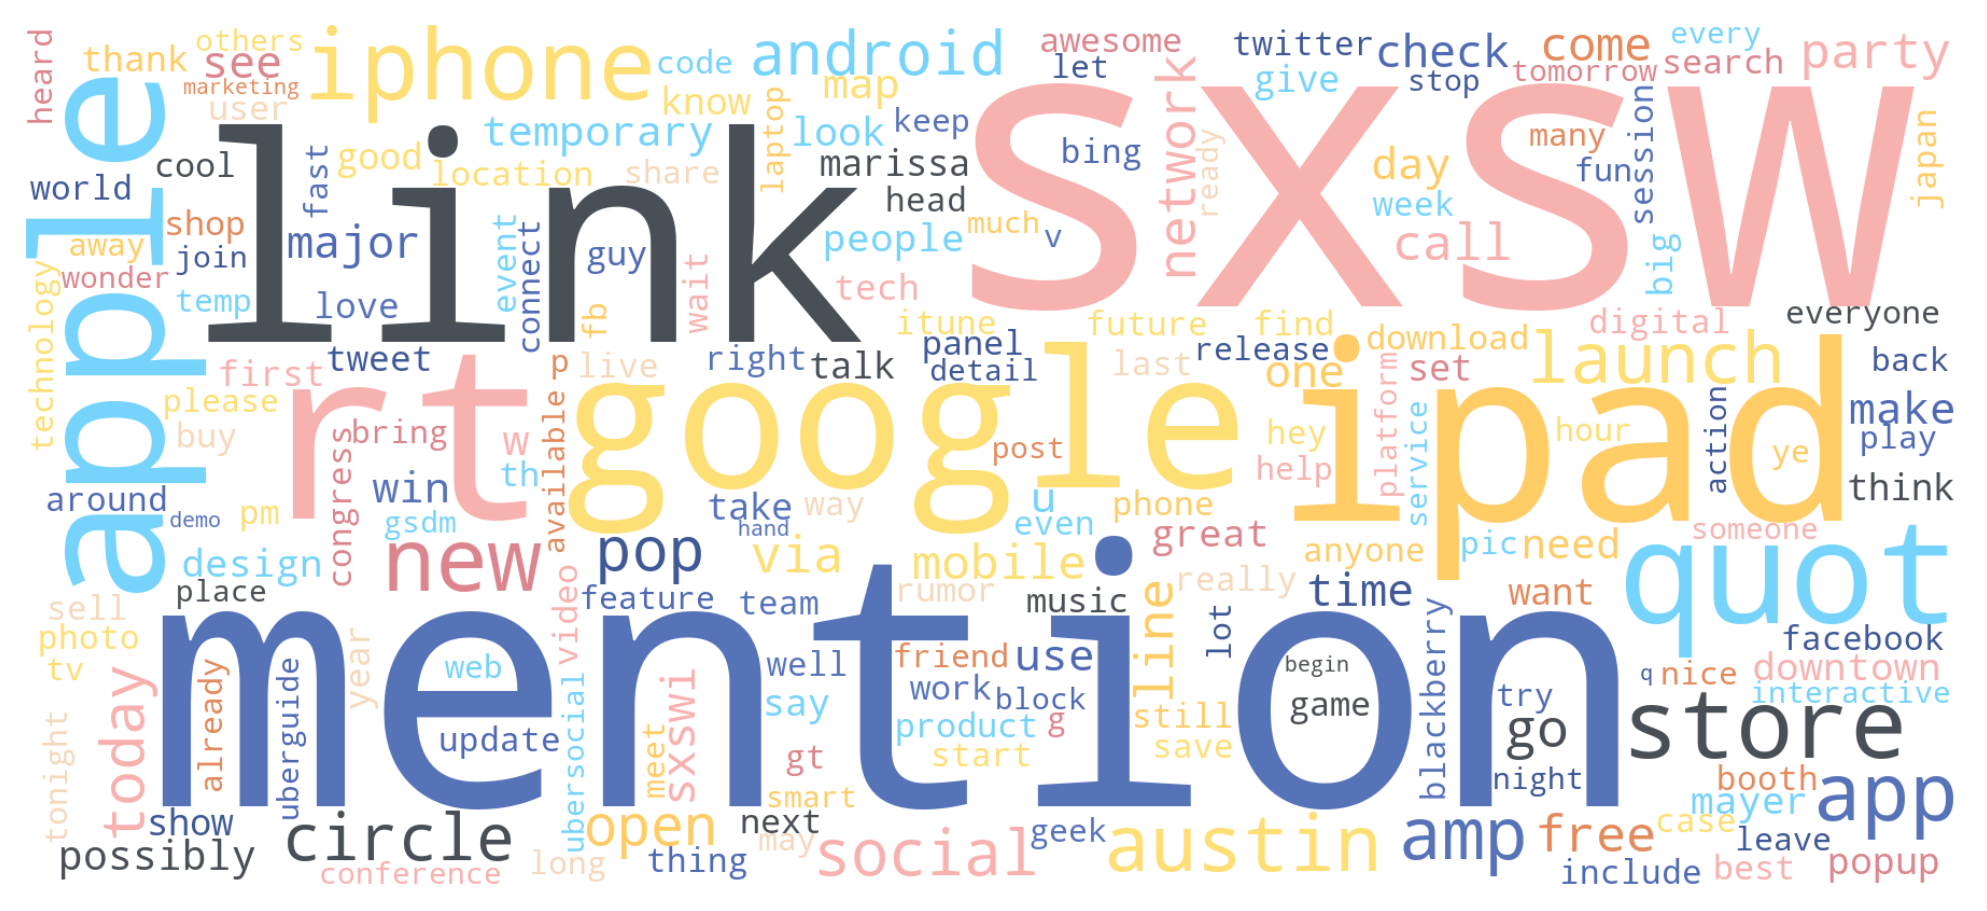

In [13]:
cloud = sentiments.copy()

cloud['tokenized'], cloud['tokens'] = \
    preprocess(cloud['tweet_text'], ret_tokens=True)

cloud['tokens_str'] = [' '.join(token_list) for token_list in cloud['tokens']]

raw_map = ['#3f5896', '#494f56', '#4f6ab3',
           '#5773b8', '#76d3fb', '#db868e',
           '#e28a5c', '#f4d9bc', '#f7b2b0',
           '#fddf75', '#ffcc66'
          ]

canvamap = ListedColormap(raw_map)
    
    
wordcloud = WordCloud(
    collocations=False, width=1800, height=800,
    colormap=canvamap, background_color='#ffffff'
).generate(" ".join(cloud['tokens_str']))

plt.figure(figsize=(10, 14), dpi=250)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [14]:
sw = stopwords.words('english')
specific_words = ['@mention','link','sxsw','#sxsw','@sxsw']
# ^^ these are the original extended stop words from initial data
# discovery and knowledge 
discovered_words = [
    'google','iphone', 'ipad', 'android', 'app',
    'apple', 'rt', 'quot', 'store', 'new', 'austin'
    ]
specific_words.extend(discovered_words)
sw.extend(specific_words)

In [15]:
preprocess(sentiments.head()['tweet_text'],sw)

['@wesley g hr tweet #rise dead need upgrade plugin station',
 '@jessedee know @fludapp awesome likely appreciate design also give free t',
 '@swonderlin wait #ipad also sale',
 'hope year festival crashy year',
 '@sxtxstate great stuff fri marissa mayer tim reilly tech book conference amp matt mullenweg wordpress']

In [16]:
sentiments['tokenized'], sentiments['tokens'] = \
    preprocess(sentiments['tweet_text'],sw=sw,ret_tokens=True)

We discovered that there were several words that occurred frequently across all sentiments, and we needed to remove them to enhance our model's effectiveness. By removing these less meaningful words, we isolated the significant keywords that have the most impact on each sentiment. The charts display the top ten most frequent words in each sentiment, after removing these less impactful words. We also found it interesting that the word "like" was commonly used in negative tweets in our dataset.1

Index(['get', 'launch'], dtype='object')


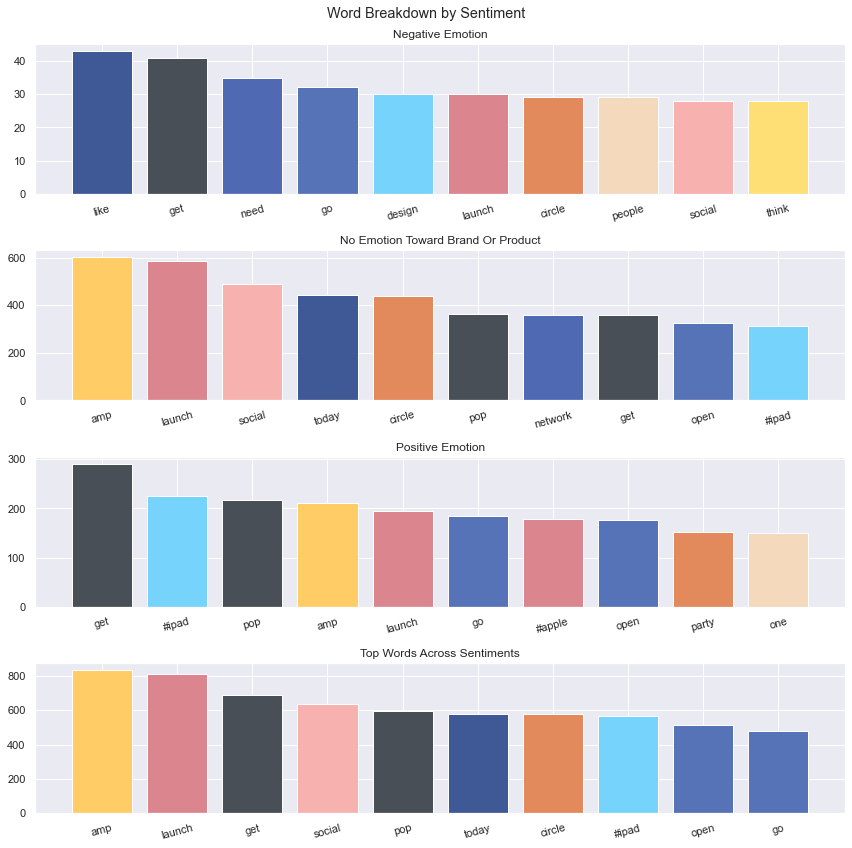

In [17]:
freq_words = word_plot(sentiments, 'sentiment', 'tokens',
    n_words=10, theme=raw_map)
print(freq_words[1])

In [18]:
X = sentiments[['tokenized','tokens']]
y = sentiments['sentiment']

X_train, X_test, y_train, y_test = \
    train_test_split(X,y,
        test_size=0.2,
        stratify=y,random_state=13)

train = X_train.merge(
    y_train,left_index=True,right_index=True
    )
test = X_test.merge(
    y_test,left_index=True,right_index=True
    )

Index(['#ipad', 'get', 'launch', 'line'], dtype='object')


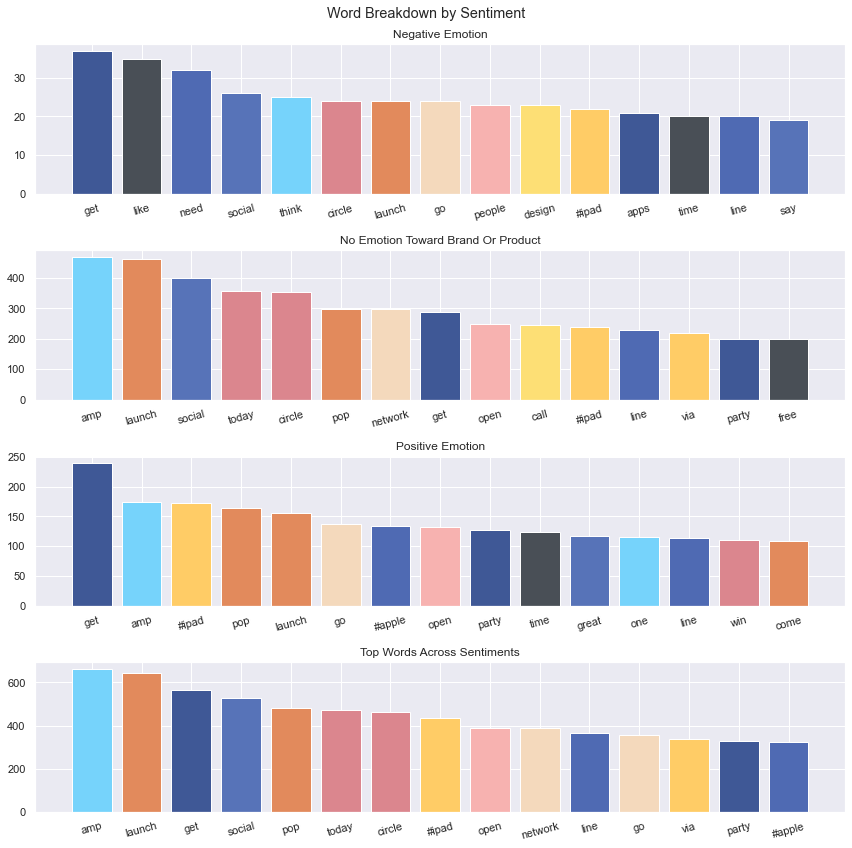

In [20]:
# train = X_train.merge(
#     y_train,left_index=True,right_index=True
#     )
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15, theme=raw_map)
print(freq_words[1])

Index(['amp', 'go', 'social'], dtype='object')


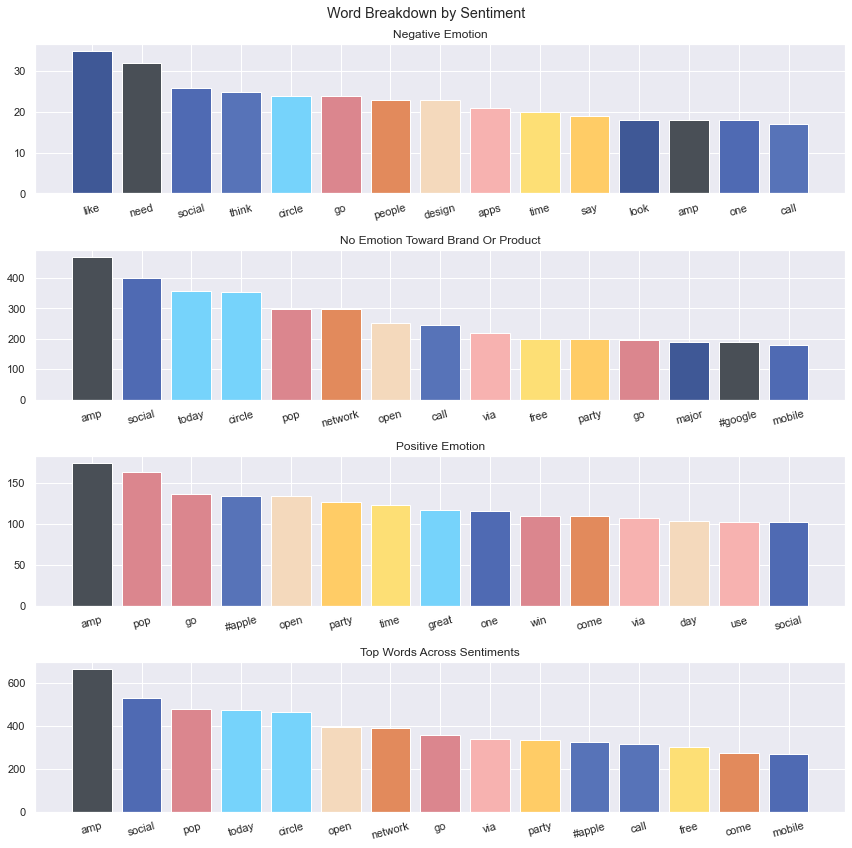

In [22]:
sw.extend(freq_words[1])
train['tokenized'], train['tokens'] = preprocess(train['tokenized'],sw,ret_tokens=True)
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15, theme=raw_map)
print(freq_words[1])

Index(['today'], dtype='object')


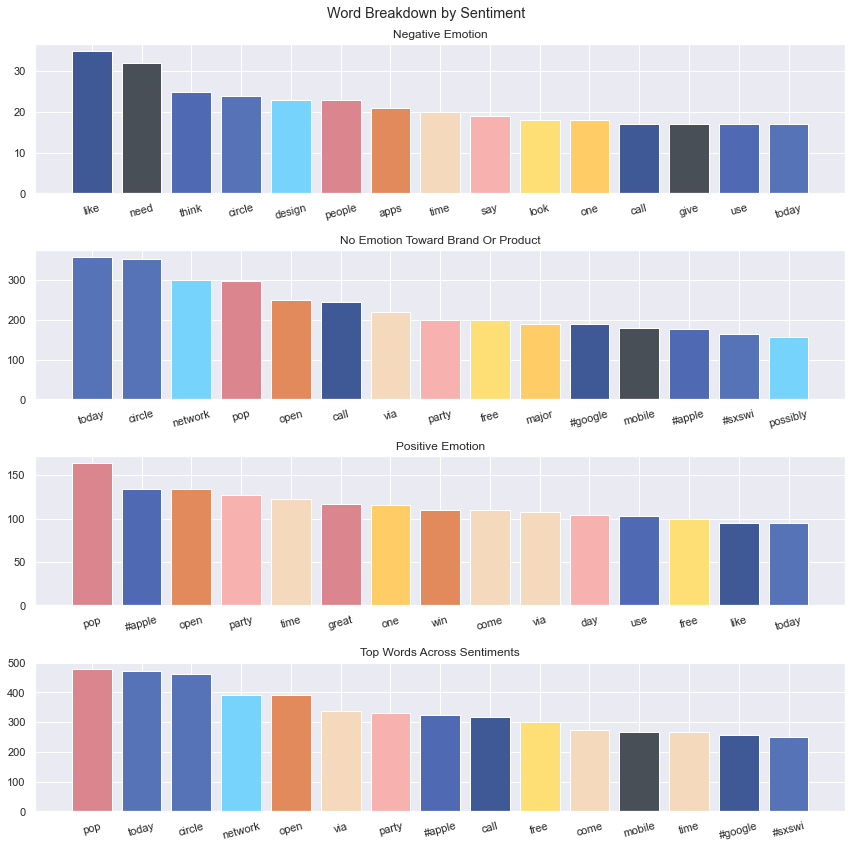

In [24]:
sw.extend(freq_words[1])
train['tokenized'], train['tokens'] = preprocess(train['tokenized'],sw,ret_tokens=True)
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15, theme=raw_map)
print(freq_words[1])

Index([], dtype='object')


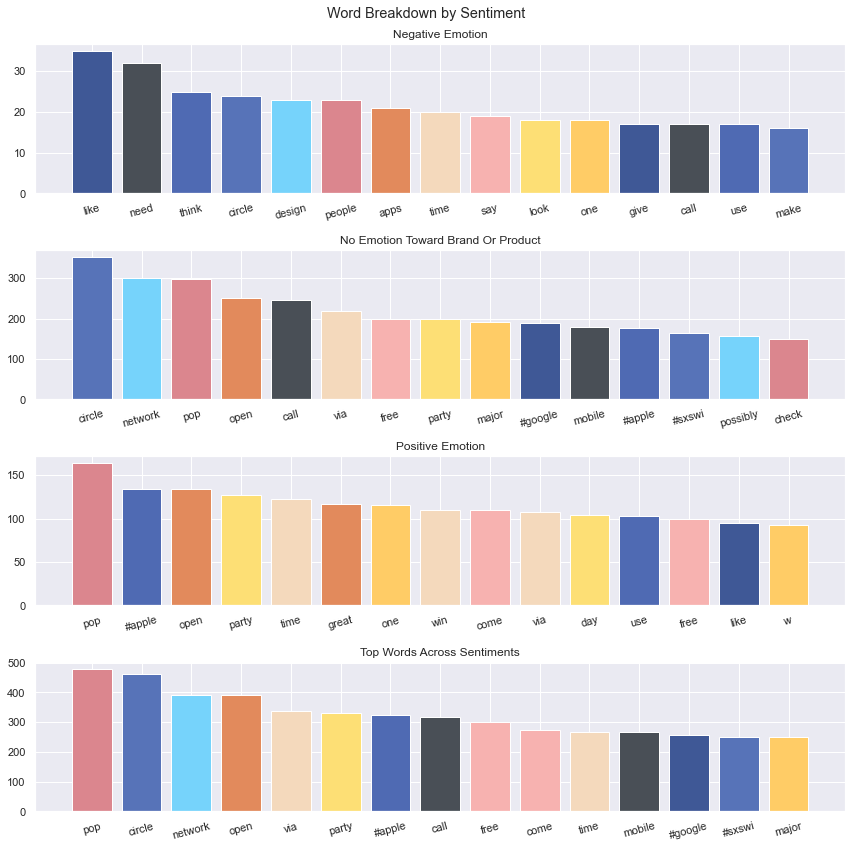

In [26]:
sw.extend(freq_words[1])
train['tokenized'], train['tokens'] = preprocess(train['tokenized'],sw,ret_tokens=True)
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15, theme=raw_map)
print(freq_words[1])

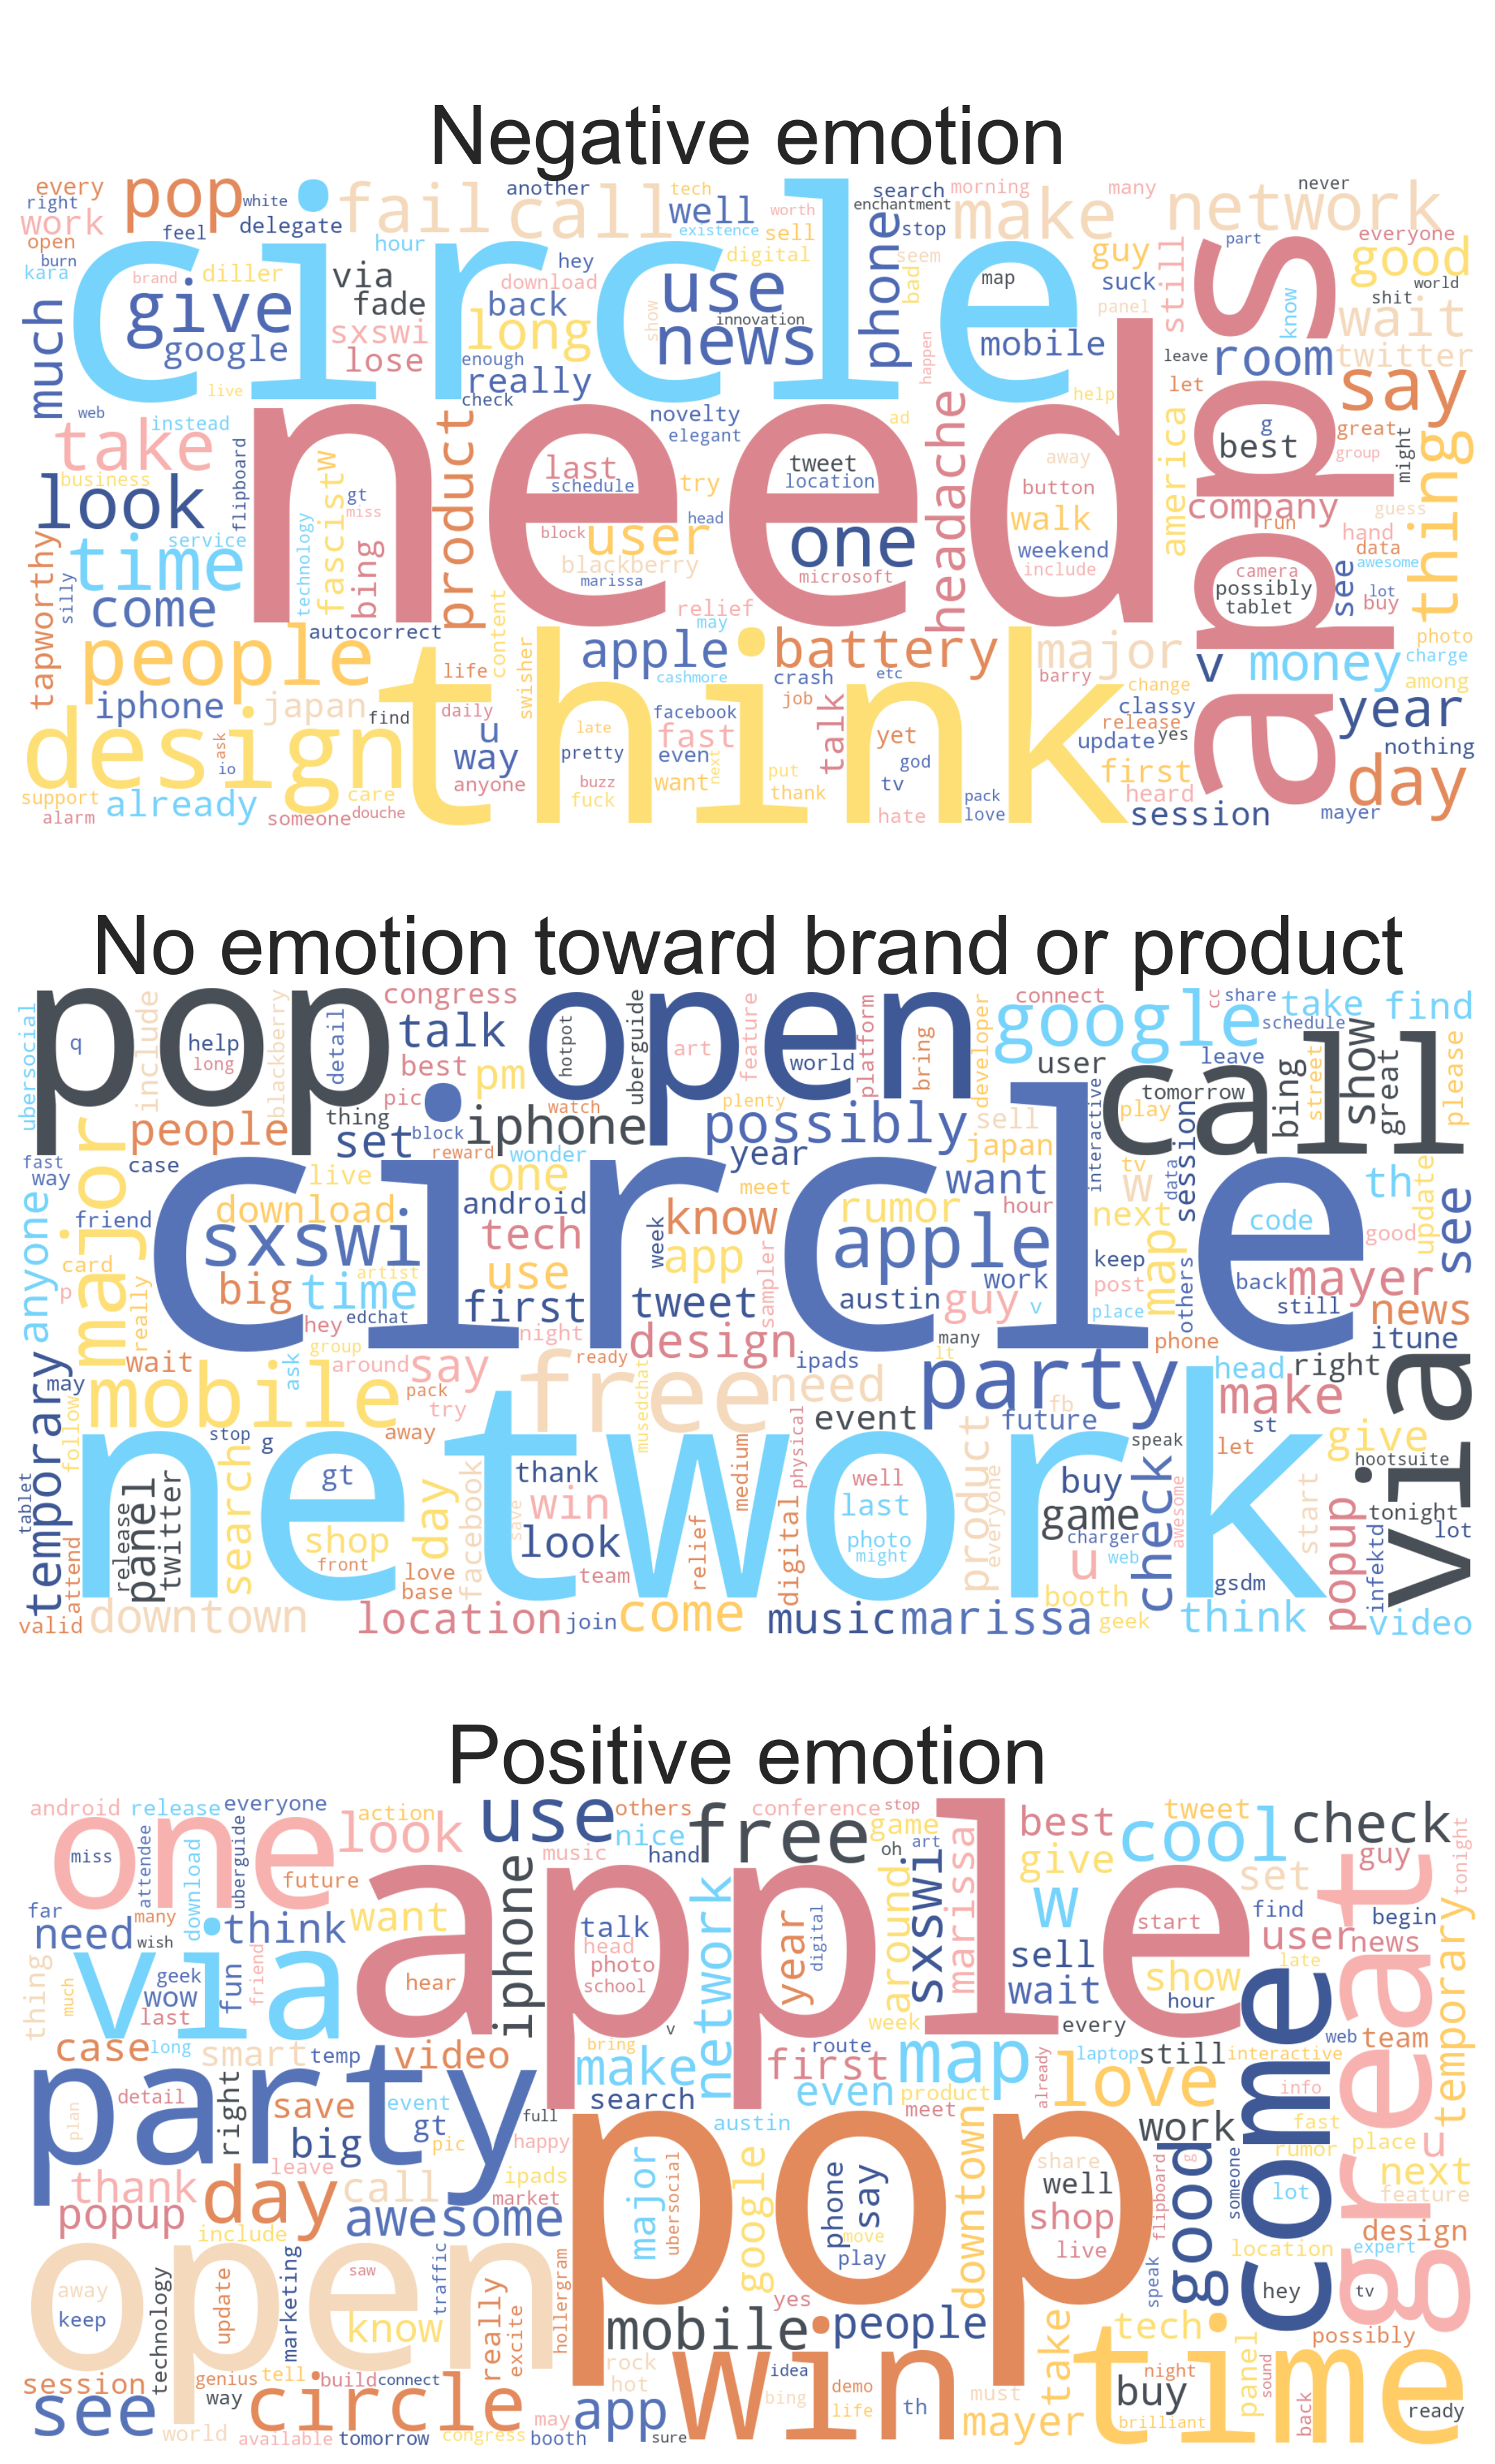

In [27]:
fig, ax = plt.subplots(3,1,figsize=(10,14),dpi=250)
for i, emo in enumerate(train['sentiment'].unique()):
    tmp_ = train[train['sentiment'] == emo]
    ax_ = ax[i]
    wordcloud = WordCloud(
        collocations=False, width=1800,height=800,
        background_color="#ffffff00",
        colormap=canvamap
        ).generate(' '.join(tmp_['tokenized']))
    ax_.set_title(f"\n{emo}",fontsize=34)
    ax_.imshow(wordcloud, interpolation='bilinear')
    ax_.axis('off')
plt.tight_layout(pad=0)

(-0.5, 1799.5, 799.5, -0.5)

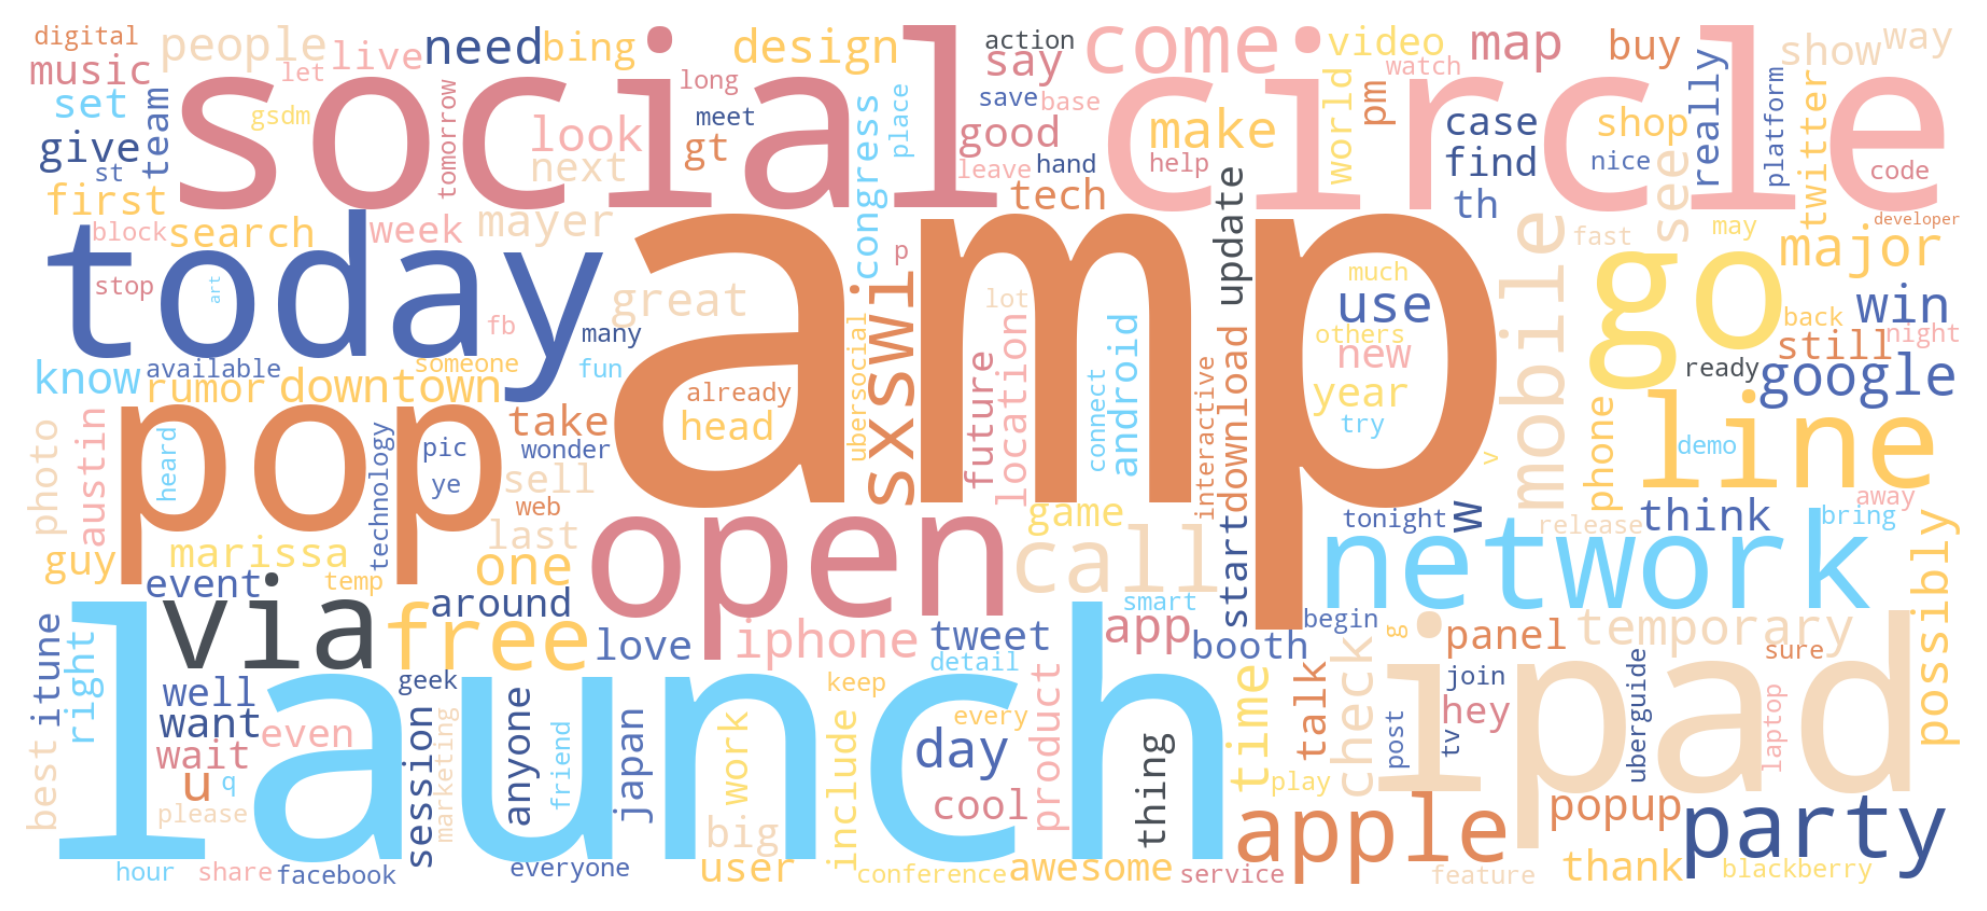

In [28]:
fig, ax = plt.subplots(1,1,figsize=(10,8),dpi=250)
wordcloud.generate(' '.join(sentiments['tokenized']))
ax.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

We can see that the word "Circle" appears at a high
volume in every category. Looking through the data,
this is because Google launched a social network called
"Circle" that was a large topic during the SXSW event
that was taking place during the time of our dataset's
collection.

In [29]:
sw.extend(['circle'])
train['tokenized'],train['tokens'] = \
    preprocess(train['tokenized'],sw,ret_tokens=True)

In [30]:
test['tokenized'], test['tokens'] = preprocess(test['tokenized'],sw,ret_tokens=True)
tfidf = TfidfVectorizer(ngram_range=[1,3],max_df=0.4,min_df=20)

train_tfidf = tfidf.fit_transform(train['tokenized'])
test_tfidf = tfidf.transform(test['tokenized'])

train_vec = pd.DataFrame(train_tfidf.toarray(),columns=tfidf.get_feature_names())
test_vec = pd.DataFrame(test_tfidf.toarray(),columns=tfidf.get_feature_names())

In [31]:
test['tokenized'], test['tokens'] = preprocess(test['tokenized'],sw,ret_tokens=True)
test_tfidf = tfidf.transform(test['tokenized'])
test_vec = pd.DataFrame(test_tfidf.toarray(),columns=tfidf.get_feature_names())

In [32]:
# rfc = RandomForestClassifier(n_jobs=-2,random_state=13)
# knc = KNeighborsClassifier(n_jobs=-2)
# mnb = MultinomialNB()
# svc = SVC(random_state=13)

# scoring = make_scorer(custom_scorer)

# rfc_grid = {
#     'max_depth':[15,20,25,30],
#     'min_samples_split':[10,15,20]
# }
# knc_grid = {
#     'n_neighbors':[3,5,7,9]
# }
# mnb_grid = {
# }
# svc_grid = {
#     'kernel':['poly','rbf'],
#     'degree':[3,4]
# }

# rfc = GridSearchCV(
#     rfc,rfc_grid,
#     scoring=scoring
# )
# knc = GridSearchCV(
#     knc,knc_grid,
#     scoring=scoring
# )
# mnb = GridSearchCV(
#     mnb,mnb_grid,
#     scoring=scoring
# )
# svc = GridSearchCV(
#     svc,svc_grid,
#     scoring=scoring
# )

# classifiers = [rfc,knc,mnb,svc]

# majority_length = len(train[train['sentiment'] == 'No emotion toward brand or product'])
# sub_majority_length = len(train[train['sentiment'] == 'Positive emotion'])

# if sub_majority_length*2 > majority_length:
#     scale_size = sub_majority_length*2
# else:
#     scale_size = majority_length

# sm_dict = {
#     "No emotion toward brand or product"    : int(scale_size),
#     "Positive emotion"                      : int(scale_size*0.5),
#     "Negative emotion"                      : int(scale_size*0.5)
# }

# o = SMOTE(random_state=13)
# # o_grid = {
# #     'sampling_strategy':['minority','auto',sm_dict]
# # }
# o_grid = ['minority','auto',sm_dict]

# # o = GridSearchCV(
# #     o,o_grid,
# #     scoring=scoring
# # )
# pipe = imbPipeline(
#     steps=[
#         ('o',o),
#         ('search',DummyClassifier())
#     ]
# )

# grid = [
#     {'o':['passthrough'],
#      'search':[*classifiers]},
#     {'o':[o],
#     'o__sampling_strategy':o_grid,
#     'search':[*classifiers]}
# ]

In [33]:
# gs = GridSearchCV(
#     pipe,grid,scoring=scoring,
#     verbose=3
# )

In [34]:
# # even with parallel backend, this process takes ~45
# # minutes to run on 23 cores. 
# with parallel_backend('threading',n_jobs=-2):
#     gs.fit(train_vec,train['sentiment'])
# 
# # dump() is used to output the estimator as a file so
# # that it can be loaded later. 
# dump(gs.best_estimator_,'./data/best_estimator.pkl')

In [35]:
# dump(gs.best_estimator_,'./data/best_estimator.pkl')

In [36]:
# gs.best_estimator_, \
# gs.best_estimator_['search'], \
# gs.best_estimator_['search'].best_params_, \
# gs.best_score_

The best estimator determined by this process was a
pipeline with default values for SMOTE and for SVC.

In [37]:
# best_top   = gs.best_estimator_.steps[0][1]
# best_inner = gs.best_estimator_['search'].best_estimator_
# best_model = imbPipeline(
#     steps=[
#         ('scaler',best_top),
#         ('model',best_inner)
#     ]
# )
# # this will load our preserved model from earier 
best_model = load('./data/best_estimator.pkl')

In [38]:
with parallel_backend('threading',n_jobs=-2):
    best_model.fit(train_vec,train['sentiment'])

In [39]:
best_model

Pipeline(steps=[('scaler', SMOTE(random_state=13)),
                ('model', SVC(random_state=13))])

In [40]:
y_pred = best_model.predict(train_vec)
train['sentiment'].value_counts(), \
(fs_arr := f1_score(y_pred,train['sentiment'],average=None)), \
fs_arr[1:].mean()

(No emotion toward brand or product    4310
 Positive emotion                      2382
 Negative emotion                       456
 Name: sentiment, dtype: int64,
 array([0.79890311, 0.90939044, 0.8579932 ]),
 0.8836918210447277)

Our predictions on our training data look pretty decent
with our model picking up on around 88% of our positive
and negative values.

In [41]:
test_pred = best_model.predict(test_vec)
test['sentiment'].value_counts(), \
(fs_arr := f1_score(test_pred,test['sentiment'],average=None)), \
fs_arr[1:].mean()

(No emotion toward brand or product    1078
 Positive emotion                       596
 Negative emotion                       114
 Name: sentiment, dtype: int64,
 array([0.36866359, 0.74495742, 0.57624113]),
 0.6605992764749453)

| | Negative | Neutral | Positive |
|---| :---: | :---: | :---: |
| **Negative** | True-Neg | FNeu-Neg | FP-Neg |
| **Neutral** | False-Neg-Neu | True-Neu | False-P-Neu |
| **Positive** | False-Neg | False-Neu-Pos | TP |

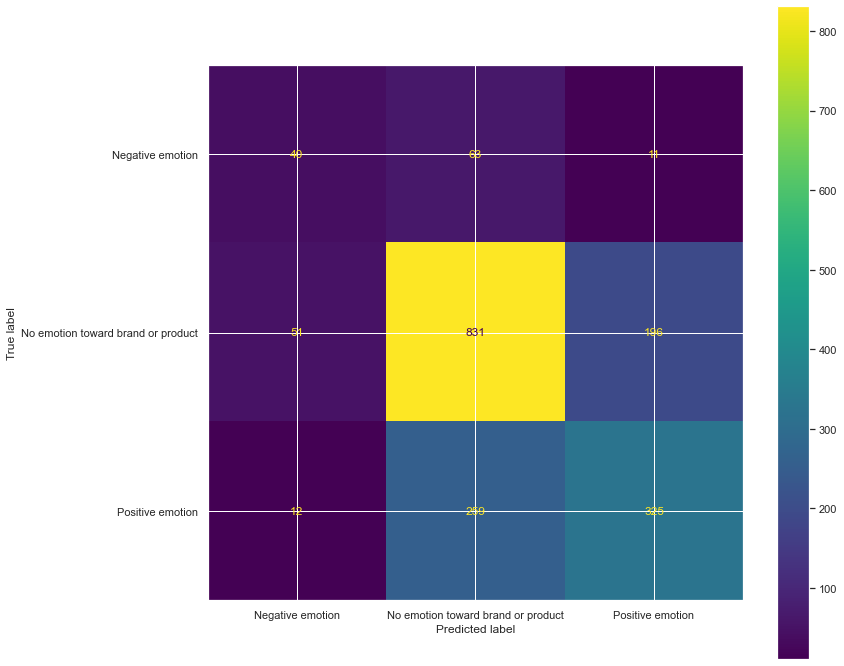

In [52]:
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(best_model, test_vec, test['sentiment'], ax=ax);

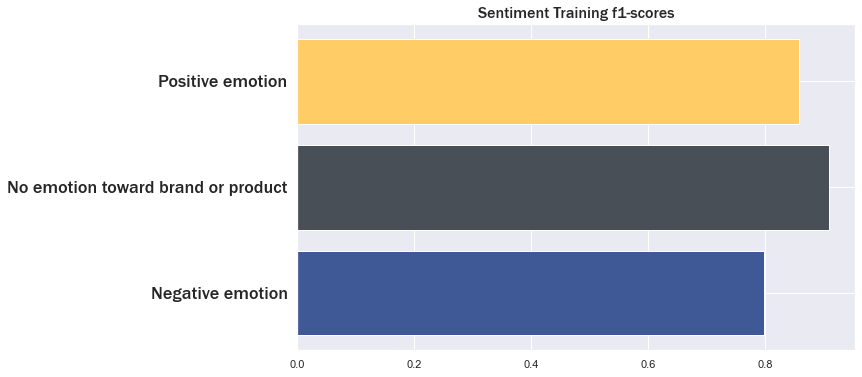

In [46]:
f1_scores = f1_score(train['sentiment'], y_pred, average=None)

sentiment_categories = sorted(np.unique(train['sentiment']))

colors = ['#3f5896', '#494f56', '#ffcc66']

plt.figure(figsize=(10, 6))
plt.barh(sentiment_categories, f1_scores, color=colors, )
#plt.xlabel('F1 Score', fontsize=14)
plt.title('Sentiment Training f1-scores', fontsize=16, fontname='Franklin Gothic Medium')
#plt.xticks(fontsize=12, fontname='Franklin Gothic Medium')
plt.yticks(fontsize=18, fontname='Franklin Gothic Medium')
plt.show()

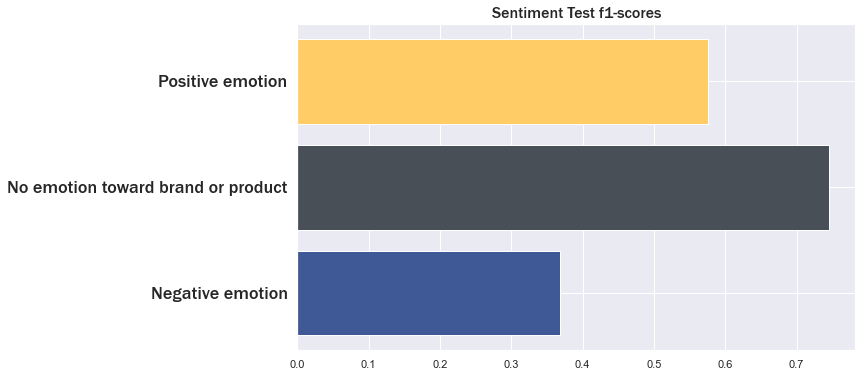

In [47]:
preds = best_model.predict(test_vec)

f1_scores = f1_score(test['sentiment'], test_pred, average=None)

sentiment_categories = sorted(np.unique(test['sentiment']))

colors = ['#3f5896', '#494f56', '#ffcc66']

plt.figure(figsize=(10, 6))
plt.barh(sentiment_categories, f1_scores, color=colors, )
#plt.xlabel('F1 Score', fontsize=14)
plt.title('Sentiment Test f1-scores', fontsize=16, fontname='Franklin Gothic Medium')
#plt.xticks(fontsize=12, fontname='Franklin Gothic Medium')
plt.yticks(fontsize=18, fontname='Franklin Gothic Medium')
plt.show()

Our model looks pretty over-fit at this point. We're
getting about a 66% f1 score on our testing data, which
is pretty close to what our CV scores were earlier on
in the process. This may not be perfect, but it can
still give us some pretty reasonable insights into our
data and may make the process of hunting down problems
that the public is concerned about.

Let's take a look at something we found earlier -
entries that were marked as "I can't tell."

This isn't really something we can automatically verify
and score against without some extra data entry, but we
can subjectively gauge our model's effectiveness at a
cursory level.

In [42]:
rc_est = preprocess(reclassify['tweet_text'],sw)
rc_tfidf = tfidf.transform(rc_est)
rc_vec = pd.DataFrame(rc_tfidf.toarray(),columns=tfidf.get_feature_names())
reclassify['predicted_sentiment'] = best_model.predict(rc_vec)


In [53]:
rc_neu = reclassify[
    reclassify['predicted_sentiment']=='No emotion toward brand or product'
    ].sample(5)['tweet_text'].values
rc_neg = reclassify[
    reclassify['predicted_sentiment']=='Negative emotion'
    ].sample(5)['tweet_text'].values
rc_pos = reclassify[
    reclassify['predicted_sentiment']=='Positive emotion'
    ].sample(5)['tweet_text'].values

tweet_types = [
    ('Neutral tweets',rc_neu),
    ('Positive tweets',rc_pos),
    ('Negative tweets',rc_neg)]
md = []
nlc = '\n'
for type_ in tweet_types:
    header = f"\n\n<br/>\n<br/>\n\n | {type_[0]} |\n|---|"
    body = []
    for item_ in type_[1]:
        body.append(f"| {item_} |")
    md.append(f"{header}\n{nlc.join(body)}")

Markdown('\n'.join(md))



<br/>
<br/>

 | Neutral tweets |
|---|
| Vai comeÌ¤ar a palestra do  @mention ex-chief evangelist of Apple #sxsw |
| How can google load those maps so fast, yet I can barely post a tweet haha #sxsw |
| Sitting at a bar listening to music w 3 ppl who r all nose down on iPhone. Waitress looks confused. #sxsw |
| Like @mention I've now seen most of Austin in Google Streetview checking out apartments for #sxsw. Austin is not easy on the click. |
| #sxsw: @mention We think we control our identities on Facebook, but as Google becomes an AI our profile will be built of what we do |


<br/>
<br/>

 | Positive tweets |
|---|
| Comprando mi iPad 2 en el #SXSW (@mention Apple Store, SXSW w/ 62 others) {link} |
| How much you want to bet Apple is disproportionately stocking the #SXSW pop-up store with iPad 2? The influencer/hipsters thank you |
| Nuts.  ÛÏ@mention @mention (via @mention #sxsw ipad store sold out of everything except 64gig wifi only whiteÛ |
| RT @mention Hmm....only 9? #SXSW right-brain #mwrc11 left-brain?? :) RT @mention @mention at #SXSW 9 out of 10 attendees have Mac or iPad |
| It's funny watching a room full of people hold their iPad in the air to take a photo. Like a room full of tablets staring you down. #SXSW |


<br/>
<br/>

 | Negative tweets |
|---|
| #UXdes @mention is glad there are no standard #iPad navigation tools. She might be the only one! #SXSW |
| SYD #SXSW crew your iPhone extra juice pods have been procured. |
| Always wanted this! RT @mention Sound of My Voice was shot exploiting Apple &amp; Best Buy's 14-day return policy on iMacs. Brilliant. #sxsw |
| @mention RWW: Google Circles will be ______    #sxsw {link} |
| TR @mention Google (tries again) to launch a new social network called Circles: {link} #sxsw {link} |

# Next Steps:

To improve our model, our next steps include:
1. analyzing brand information in our dataset to see if adding context enhances model performance. 
2. We will also explore other modeling systems to achieve better results
3. Consider non-English tweets
4. Implement an updating system that continuously incorporates new and updated tweets, enabling the model to adapt to evolving language context.
These steps will, hopefully, enhance the effectiveness and generalizability of our model to better predict tweet sentiment.

![thank_you_pic](./img/thank_you.png)